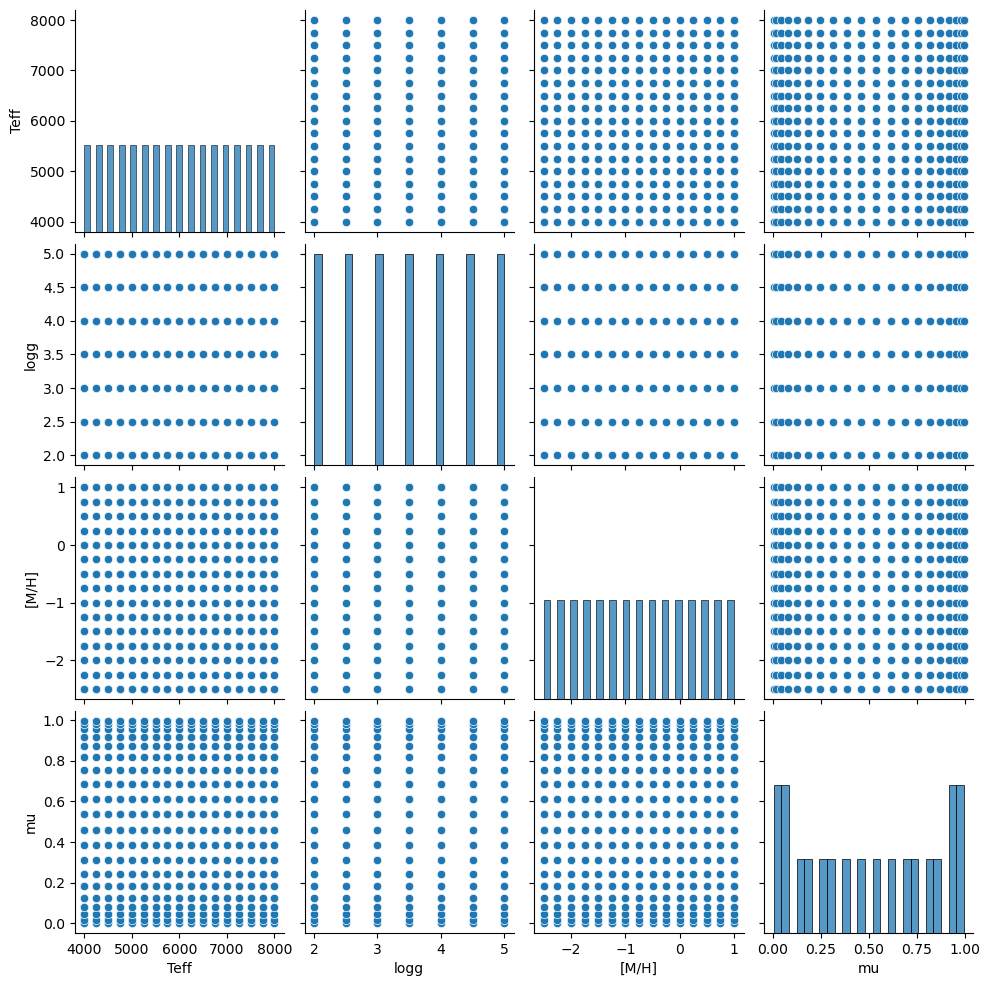

/jobfs/129836601.gadi-pbs/ipykernel_2487866/4253161824.py:92: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


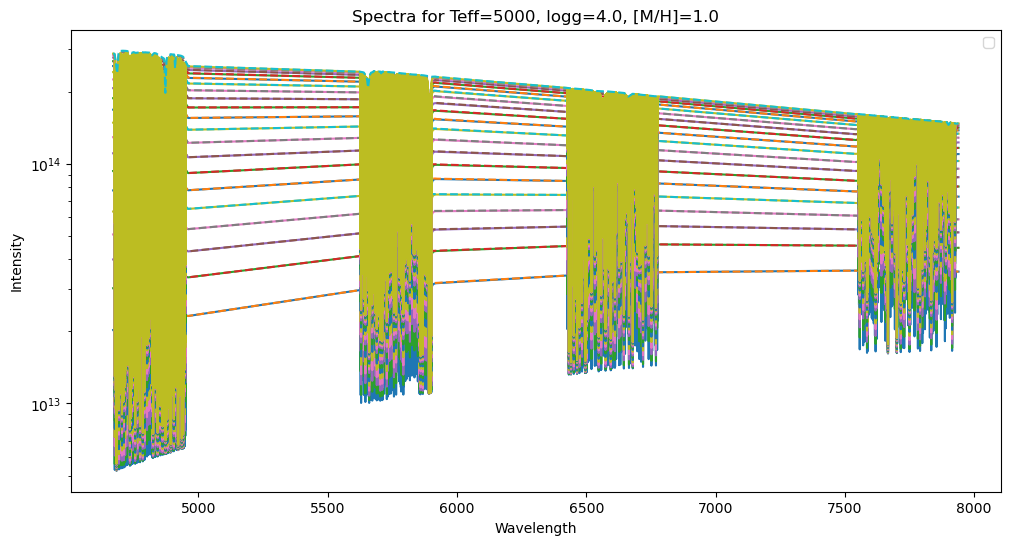

In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to read the HDF5 file
def read_hdf5_file_to_dict(filename):
    """
    Reads an HDF5 file and returns its contents as NumPy arrays in a dictionary.

    Parameters:
        filename (str): Path to the HDF5 file.

    Returns:
        dict: A dictionary containing the datasets read from the HDF5 file.
    """
    data_dict = {}
    with h5py.File(filename, 'r') as f:
        for key in ['parameters', 'sp_intensity', 'sp_no_lines_intensity']:
            data_dict[key] = np.array(f[key])
        data_dict["log10_sp_wave"] = np.array(f["log10_sp_wave"])
        data_dict["log10_sp_no_lines_wave"] = np.array(f["log10_sp_no_lines_wave"])
    return data_dict

# Read the HDF5 file
filename = '/scratch/y89/tr0953/korg_grid_calculation/ready_grids/regular_grid.h5'
data = read_hdf5_file_to_dict(filename)

# Extract the parameters
parameters = data['parameters']

df_params = pd.DataFrame({
    'Teff': parameters[:, 0],
    'logg': parameters[:, 1],
    '[M/H]': parameters[:, 2],
    'mu': parameters[:, 3]
})

# Create a 4x4 grid of scatter plots
sns.pairplot(df_params)
plt.show()


# Plot 2:
# ------------------------------------------------

# User selection of Teff, logg, and [M/H]
selected_Teff = 5000  # Replace with desired Teff value
selected_logg = 4.0   # Replace with desired logg value
selected_MH = 1.0     # Replace with desired [M/H] value

# Filter the data based on the selected parameters
selection_mask = (
    (parameters[:, 0] == selected_Teff) &
    (parameters[:, 1] == selected_logg) &
    (parameters[:, 2] == selected_MH)
)

# Indices of the selected data
selected_indices = np.where(selection_mask)[0]

# Check if any data matches the selection
if len(selected_indices) == 0:
    print("No data found for the selected Teff, logg, and [M/H].")
else:
    # Initialize the plot
    plt.figure(figsize=(12, 6))
    
    # Plot spectra for each selected index
    for idx in selected_indices:
        # Spectra with lines
        sp_wave = data['log10_sp_wave']
        sp_intensity = data['sp_intensity'][idx]
        # Spectra without lines
        sp_no_lines_wave = data['log10_sp_no_lines_wave']
        sp_no_lines_intensity = data['sp_no_lines_intensity'][idx]
        
        # Retrieve the mu value for labeling
        mu_value = parameters[idx, -1]
        
        # Plotting the spectra
        cont = np.interp(sp_wave, sp_no_lines_wave, sp_no_lines_intensity)
        plt.plot(10**sp_wave, sp_intensity * cont)
        plt.plot(10**sp_no_lines_wave, sp_no_lines_intensity, linestyle='--')
    
    # Customize the plot
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.title(f'Spectra for Teff={selected_Teff}, logg={selected_logg}, [M/H]={selected_MH}')
    plt.yscale('log')
    plt.legend()
    plt.show()

In [2]:
data['parameters'].shape

(35700, 4)

In [3]:
# data_big = read_hdf5_file_to_dict('/scratch/y89/tr0953/korg_grid_calculation/ready_grids/regular_grid.h5')

In [3]:
from jax.scipy.interpolate import RegularGridInterpolator


In [4]:
data['sp_intensity'].shape

(35700, 65992)

In [5]:
# Create interpolator for each wavelength point
from tqdm import tqdm

wavelengths = data['log10_sp_wave']
    # Get intensity values for this wavelength
intensities = data['sp_intensity']

# Create interpolator using parameters as points and intensities as values
# Extract unique parameter values for each dimension
teff_vals = np.unique(data['parameters'][:, 0])
logg_vals = np.unique(data['parameters'][:, 1]) 
mh_vals = np.unique(data['parameters'][:, 2])
alpha_vals = np.unique(data['parameters'][:, 3])

# Create interpolator with parameter grids
interp = RegularGridInterpolator((teff_vals, logg_vals, mh_vals, alpha_vals, wavelengths), 
                                intensities.reshape(len(teff_vals), len(logg_vals), 
                                                    len(mh_vals), len(alpha_vals), 65992))


In [7]:
data['log10_sp_wave'][0]

3.669317400765426

In [6]:
import jax
import jax.numpy as jnp


interp(np.array([5000, 4.0, 1.0, 0.02, data['log10_sp_wave'][0]]))
interpolate_spectrum = jax.vmap(lambda p, w: interp(jnp.concatenate([p, jnp.array([w])])), in_axes=(None, 0))

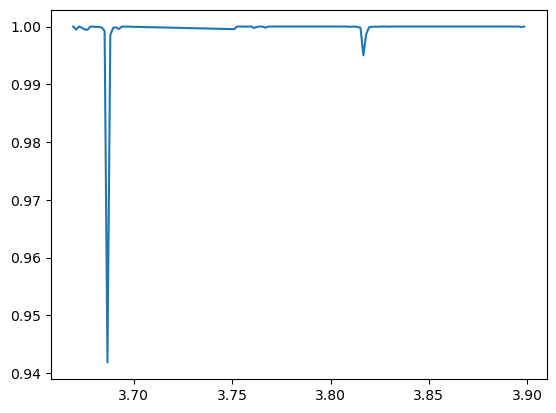

In [8]:
parameters = jnp.array([5000, 4.0, 1.0, 0.02])
spec = interpolate_spectrum(parameters, data['log10_sp_wave'][::1000])
plt.plot(data['log10_sp_wave'][::1000], spec)
plt.show()


In [13]:
# # Save interpolator to pickle file
# import pickle

# print("Saving interpolator to pickle file...")
# with open('scr/mj8805/spectra_interpolator.pkl', 'wb') as f:
#     pickle.dump(interp, f)
# print("Done saving interpolator")


Saving interpolator to pickle file...
Done saving interpolator


In [14]:
np.unique(data['parameters'][:, 0])

array([4000., 4250., 4500., 4750., 5000., 5250., 5500., 5750., 6000.,
       6250., 6500., 6750., 7000., 7250., 7500., 7750., 8000.])

In [17]:
# Create a grid of points halfway between original grid points
import itertools

# Set JAX to use 64-bit precision
jax.config.update("jax_enable_x64", True)


wavelengths = data['log10_sp_wave']

# Extract unique parameter values for each dimension
teff_vals = np.unique(data['parameters'][:, 0])
logg_vals = np.unique(data['parameters'][:, 1]) 
mh_vals = np.unique(data['parameters'][:, 2])
alpha_vals = np.unique(data['parameters'][:, 3])

# Calculate midpoints between grid values
teff_mid = np.unique((teff_vals[:-1] + teff_vals[1:]) / 2)
logg_mid = np.unique((logg_vals[:-1] + logg_vals[1:]) / 2)
mh_mid = np.unique((mh_vals[:-1] + mh_vals[1:]) / 2)
alpha_mid = np.unique((alpha_vals[:-1] + alpha_vals[1:]) / 2)

# Create all combinations of midpoints
mid_points = np.array(list(itertools.product(teff_mid, logg_mid, mh_mid, alpha_mid)))

# Interpolate spectra at midpoints using previously defined interpolator
mid_spectra = jnp.array([interpolate_spectrum(mid_points[i], wavelengths) for i in tqdm(range(len(mid_points)))])

mid_interp = RegularGridInterpolator((teff_mid, logg_mid, mh_mid, alpha_mid, wavelengths), 
                                    mid_spectra.reshape(len(teff_mid), len(logg_mid), len(mh_mid), len(alpha_mid), len(wavelengths)))
mid_interp_v = jax.vmap(lambda p, w: mid_interp(jnp.concatenate([p, jnp.array([w])])), in_axes=(None, 0))


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 17596/25536 [2:17:20<57:16,  2.31it/s]

: 

In [15]:
import pickle

print("Saving interpolator to pickle file...")
with open('scr/mj8805/mid_spectra_interpolator.pkl', 'wb') as f:
    pickle.dump(mid_interp, f)
print("Done saving interpolator")

(1200, 4)

In [12]:
# Get original grid points
original_points = data['parameters']
# Interpolate original spectra at same wavelength points for comparison
original_spectra = [mid_interp_v(data['parameters'][i], wavelengths) for i in range(len(data['parameters']))]

/jobfs/128549114.gadi-pbs/ipykernel_479079/1310267842.py:2: RuntimeWarning: Mean of empty slice
  rms_error = np.nanmean((original_spectra[:, :, 0] - data['sp_intensity'])**2)


RMS error from interpolation: nan


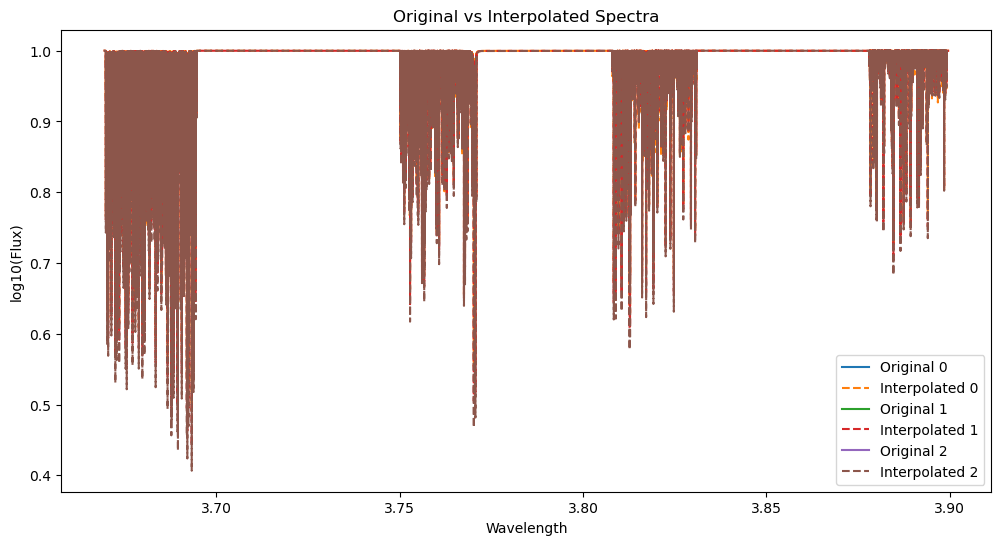

In [13]:
# Calculate RMS error between original and interpolated spectra
rms_error = np.nanmean((original_spectra[:, :, 0] - data['sp_intensity'])**2)

print(f"RMS error from interpolation: {rms_error:.6f}")

# Plot a few example spectra to visualize differences
plt.figure(figsize=(12,6))
for i in range(3):  # Plot first 3 spectra
    plt.plot(wavelengths, original_spectra[i], label=f'Original {i}')
    plt.plot(wavelengths, mid_spectra[i], '--', label=f'Interpolated {i}')
plt.xlabel('Wavelength')
plt.ylabel('log10(Flux)')
plt.title('Original vs Interpolated Spectra')
plt.legend()
plt.show()

In [14]:
original_spectra


array([[[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]],

       ...,

       [[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]]])